# Question 2:  Pose Graph Optimization for 2D SLAM

## Objective
A robot is travelling in a oval trajectory. It is equipped with wheel odometry for odometry information and RGBD sensors for loop closure information. Due to noise in wheel odometry it generates a noisy estimate of the trajectory. Our task is to use loop closure pairs to correct the drift.

We pose this problem as a graph optimization problem. In our graph, poses are the vertices and constraints are the edges. 

## Given: 
In practical scenarios, we'd obtain the following from our sensors after some post-processing:

1. Initial position
2. Odometry Contraints/Edges: This "edge" information tells us relative transformation between two nodes. These two nodes are consecutive in the case of Odometry but not in the case of Loop Closure (next point).
3. Loop Closure Contraints/Edges: Remember that while optimizing, you have another kind of "anchor" edge as you've seen in 1. solved example.

You have been given a text file named `edges.txt` (in `data/`) which has all the above 3 and it follows G2O's format (as explained in class, [link here](https://saishubodh.notion.site/G2O-Edge-Types-d9f9ff63c77c4ceeb84b1e49085004e3) ). The ground truth is `gt.txt`.

In [1]:
import numpy as np
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import helpers
from slam import get_residual, get_my_jacob, get_jax_jacob, calc_init_poses, LM


## Steps:

### Part 1

Using the following motion model, you have to first generate the "initialization" for all the poses/vertices using the "Given" information. Just like in the 1D case.
$$x_{k+1} = x_{k} + \Delta x_{(k,k+1)} \cos(\theta_k) - \Delta y_{(k,k+1)} \sin(\theta_k) \\
y_{k+1} = y_{k} + \Delta y_{(k,k+1)} \cos(\theta_k) + \Delta x_{(k,k+1)} \sin(\theta_k) \\
\theta_{k+1} = \theta_{k}+  \Delta \theta_{(k,k+1)} \tag{3}$$

Even the loop closure nodes are related by the above model, except that it need not necessarily be consecutive notes k and k+1.

Save this initial trajectory as `edges-poses.g2o`.

If you plot the initialized poses using odometry information, you need to get as the right plot below (this is the "noisy trajectory"): (Left one is the ground truth)
![robot-poses-MR-P1.png](../misc/robot-poses-MR-P1.png)

(Use `draw()` helper function or `g2o_viewer` or `EVO`)

Estimate using odometry


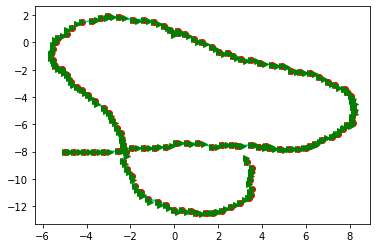

In [2]:

EDGES_FILE = '../data/edges.txt'
EDGES_POSES_FILE = '../data/edges-poses.g2o'

nodes, edges = helpers.read_data(EDGES_FILE)
fixed = nodes[:, 0]
poses = calc_init_poses(fixed, edges)
print("Estimate using odometry")
helpers.draw_one(poses[:, 0], poses[:, 1], poses[:, 2])
helpers.write_edges_poses(EDGES_POSES_FILE, EDGES_FILE, poses)


## Part 2

Now calculate the residual and the Jacobian and update your parameters using LM.

Use LM algorithm. Regarding Jacobian calculation, you can use `jax`'s `jacobian` as part of your main code. However, you still have to separately calculate it analytically and verify if it matches with `jax`'s `jacobian` using frobenius norm `frobNorm()`). Calculation and verification is compulsory, but it is your choice to use whichever as part of your optimization. Use whichever is faster. You can also visualise your Jacobian and see the structure of the matrix (just use `plt.imshow`).

**Regarding LM iterations, stopping criterion, information matrix values.**

1. As your iterations proceed, you have to print relevant information (iteration number and error value: [$F = \frac{1}{2}  \mathbf{f}^{\top} \mathbf{\Omega} \mathbf{f} $ (notes on non-linear LS)](https://saishubodh.notion.site/From-linear-algebra-to-non-linear-weighted-least-squares-optimization-13cf17d318be4d45bb8577c4d3ea4a02#32832dee7d6c4ab49581463d9b784f21) at every step).

2. You have to show the plots (ground truth, noisy & optimized: all 3 in a single plot) at every 10 steps or so.

3. You could start with information values of 500 for odom edges, 700 for loop closure edges, 1000 for anchor edge (same for all dimensions). However, you have to _heavily_ experiment with these values. (Given that you somehow know loop closure information is way more reliable than odometry.). At the end of your experimentation, your error $F = \frac{1}{2}  \mathbf{f}^{\top} \mathbf{\Omega} \mathbf{f} $ should by < 40. Explain your experimentation in detail using tables/plots etc if necessary.
    
Do not worry if you're not getting a perfect trajectory. Our parametrization was oversimplified for the sake of this project. With that being said, it is possible to get the error down to < 40 and make it at least look like an oval shaped trajectory, even if it doesn't perfectly resemble the ground truth. However, using `g2o` (seen later on), you will be getting a close to ground truth trajectory.

**Tip**

Be sure to make your code modular and implement this in various stages. It will help you debug errors. Feel free to create helper functions in other files, just be sure to submit those as well. 

You are free to optimise your code using numba/Jax/torch if you wish, just ensure that you are not using any built in functions for any of the steps. It is only compulsory to verify your Jacobian using Jax.

Comparing Jacobians
Frobenius norm between my jacobian and jax jacobian is: 0.0


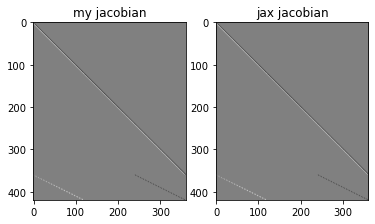

In [3]:
def compare_jacobs():
    my_jacob = get_my_jacob(poses, edges, fixed)
    jax_jacob = get_jax_jacob(poses, edges, fixed)

    print("Comparing Jacobians")
    helpers.frobNorm(my_jacob, jax_jacob, "my jacobian", "jax jacobian")
    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(my_jacob, cmap='gray')
    ax[1].imshow(jax_jacob, cmap='gray')
    ax[0].set_title('my jacobian')
    ax[1].set_title('jax jacobian')
    plt.show()

compare_jacobs()


Using Weights: (10, 100, 110)

Iteration 0: Error: 91338.84375


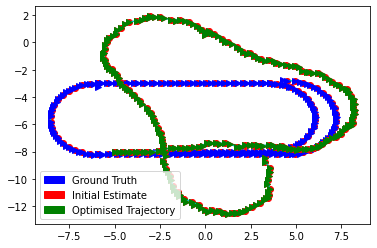

Iteration 1: Error: 16192.615234375
Iteration 2: Error: 1193.335205078125
Iteration 3: Error: 995.3889770507812
Iteration 4: Error: 363.47967529296875
Iteration 5: Error: 161.9155731201172
Iteration 6: Error: 819.5546264648438
Iteration 7: Error: 1225.3302001953125
Iteration 8: Error: 2355.22216796875
Iteration 9: Error: 3910.5751953125
Iteration 10: Error: 454.73834228515625


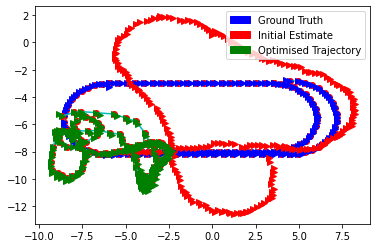

Iteration 11: Error: 49.239959716796875
Iteration 12: Error: 49.16609191894531
Iteration 13: Error: 22.64179039001465
Iteration 14: Error: 21.326557159423828
Iteration 15: Error: 30.792028427124023
Iteration 16: Error: 38.83477020263672
Iteration 17: Error: 30.57170295715332
Iteration 18: Error: 18.790382385253906
Iteration 19: Error: 16.186023712158203
Iteration 20: Error: 18.978715896606445


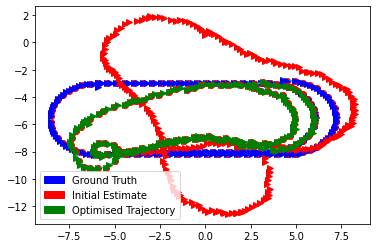

Iteration 21: Error: 16.680973052978516
Iteration 22: Error: 14.55457592010498
Iteration 23: Error: 17.8275146484375
Iteration 24: Error: 26.60519027709961
Iteration 25: Error: 36.99187469482422
Iteration 26: Error: 40.96114730834961
Iteration 27: Error: 31.161306381225586
Iteration 28: Error: 19.15918731689453
Iteration 29: Error: 38.153587341308594
Iteration 30: Error: 66.79853057861328


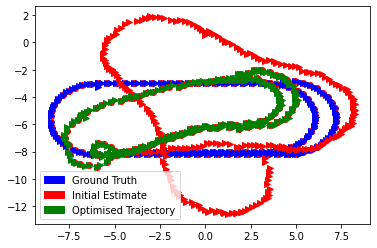

Iteration 31: Error: 49.385231018066406
Iteration 32: Error: 22.107282638549805
Iteration 33: Error: 19.56822967529297
Iteration 34: Error: 44.90315246582031
Iteration 35: Error: 104.59297180175781
Iteration 36: Error: 207.13296508789062
Iteration 37: Error: 328.2565612792969
Iteration 38: Error: 317.9472351074219
Iteration 39: Error: 94.69622802734375
Iteration 40: Error: 81.71387481689453


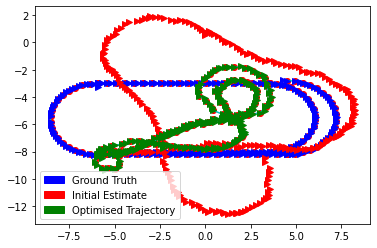

Iteration 41: Error: 342.6251220703125
Iteration 42: Error: 571.4544677734375
Iteration 43: Error: 404.1546936035156
Iteration 44: Error: 106.72113037109375
Iteration 45: Error: 30.651826858520508
Iteration 46: Error: 46.72177505493164
Iteration 47: Error: 148.0498504638672
Iteration 48: Error: 423.2913818359375
Iteration 49: Error: 1102.5428466796875
Iteration 50: Error: 2009.5418701171875


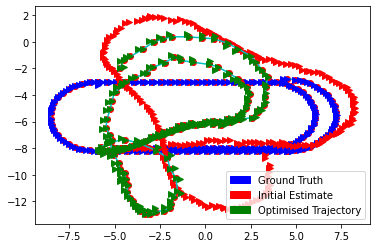

Iteration 51: Error: 1120.4365234375
Iteration 52: Error: 371.9835510253906
Iteration 53: Error: 272.727294921875
Iteration 54: Error: 108.13032531738281
Iteration 55: Error: 466.8876953125
Iteration 56: Error: 443.4759216308594
Iteration 57: Error: 355.0794372558594
Iteration 58: Error: 207.4846954345703
Iteration 59: Error: 95.73796081542969
Iteration 60: Error: 40.317596435546875


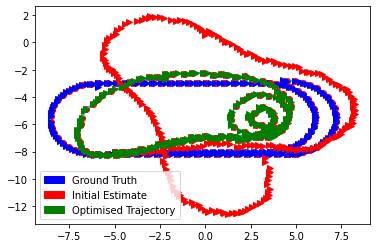

Iteration 61: Error: 22.363733291625977
Iteration 62: Error: 18.0704402923584
Iteration 63: Error: 17.134435653686523
Iteration 64: Error: 16.900999069213867
Iteration 65: Error: 16.81989860534668
Iteration 66: Error: 16.779373168945312
Iteration 67: Error: 16.754892349243164
Iteration 68: Error: 16.739303588867188
Iteration 69: Error: 16.72930335998535
Iteration 70: Error: 16.722923278808594


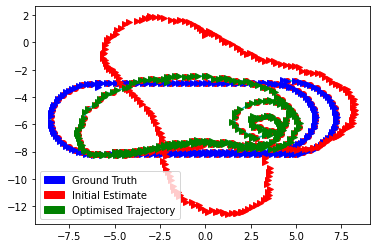

Iteration 71: Error: 16.718856811523438
Iteration 72: Error: 16.716243743896484
Iteration 73: Error: 16.714574813842773
Iteration 74: Error: 16.71351432800293
Iteration 75: Error: 16.712841033935547
Iteration 76: Error: 16.712406158447266
Iteration 77: Error: 16.712112426757812
Iteration 78: Error: 16.71193504333496
Iteration 79: Error: 16.71182632446289
Iteration 80: Error: 16.71174430847168


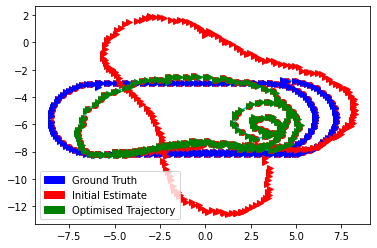

Iteration 81: Error: 16.711702346801758
Iteration 82: Error: 16.711666107177734
Iteration 83: Error: 16.711647033691406
Iteration 84: Error: 16.711639404296875
Iteration 85: Error: 16.711610794067383
Iteration 86: Error: 16.71161460876465
Iteration 87: Error: 16.71160125732422
Iteration 88: Error: 16.711610794067383
Iteration 89: Error: 16.711610794067383
Iteration 90: Error: 16.711593627929688


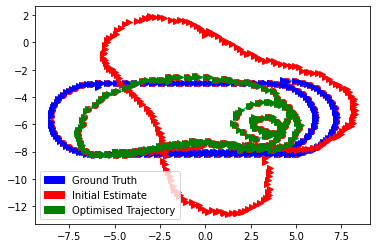

Iteration 91: Error: 16.711593627929688
Iteration 92: Error: 16.711597442626953
Iteration 93: Error: 16.711593627929688
Iteration 94: Error: 16.711585998535156
Iteration 95: Error: 16.71159553527832
Iteration 96: Error: 16.71158218383789
Iteration 97: Error: 16.711585998535156
Iteration 98: Error: 16.711584091186523
Iteration 99: Error: 16.711585998535156
Iteration 100: Error: 16.711584091186523


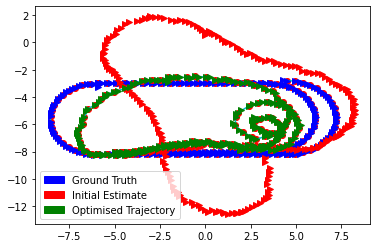

Final Error: 16.711584091186523 at itr: 101


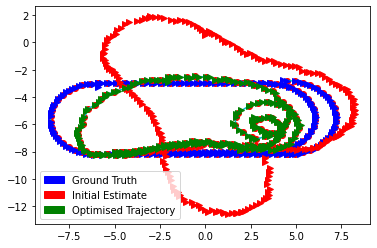

In [4]:
lm = LM(poses,edges, fixed, 0.01, 61, 1e-6, [2.5,4])
poses_arr, error_arr = lm.optimize()

## Part 3

- Write about the residuals you computed, its structure and shape. Also explain the structure of the Jacobian and its shape (Express the shape in terms of the number of vertices, loop constraints, and such, not exact numbers). 
- Write about the optimization process and any observations using intermediate plots and such. 

## Part 4

Write the final optimised trajectory as a g2o file. You can do this alongside any of the earlier parts.